In [16]:
import numpy as np

In [17]:
import os

# Transfer learning 

We start with two folders containing positive and negative samples for stadiums, due to the nature of the problem, classes are highly unbalanced. 

we'll use class_weights to reinforce positive samples (minority class).

In [18]:
stadium_images = os.listdir('stadiums/')

In [19]:
non_stadium_images = os.listdir('non_stadiums/')

In [20]:
len(non_stadium_images)

11972

In [21]:
len(stadium_images)

47

In [22]:
import pandas as pd
stadium_df = pd.DataFrame()
stadium_df['filename'] = stadium_images
stadium_df['is_stadium'] = True

In [23]:
non_stadium_df = pd.DataFrame()
non_stadium_df['filename'] = non_stadium_images
non_stadium_df['is_stadium'] = False

In [24]:
dataset_df = pd.concat([non_stadium_df,stadium_df])

In [25]:
dataset_df = dataset_df.drop(0)

# Feature Extraction

We'll use resnet50 to extract image features from the positives and negative samples. Then use those features as input
to a single layer network with dropout for classification

Let's try out feature extraction for a single image

In [26]:
from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image


In [27]:
model = resnet50.ResNet50(weights='imagenet', include_top=False)
#model.summary()

img_path = 'stadiums/Estadio Alberto J. Armando.png'
img = image.load_img(img_path, target_size=(256, 256))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

resnet_features = model.predict(img_data)
print(resnet_features)
print(resnet_features.shape)

[[[[ 0.08236177  0.05985396  0.08081593 ...,  0.16119762  0.81385475
     0.42690596]]]]
(1, 1, 1, 2048)


an image is then represented by an array of 2048 floats taken from the output of the resnet. Let's extract 
features for the rest of the stadium images

In [28]:
image_features = []
for x in stadium_images:
    if x.endswith('.png'):
        img = image.load_img('stadiums/'+x, target_size=(256, 256))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        features = model.predict(img_data)
        image_features.append(features.flatten())

In [29]:
stadium_features = image_features

In [ ]:
import random
non_stadium_features = []
for x in non_stadium_images:
    if x.endswith('.jpg'):
        img = image.load_img('non_stadiums//'+x, target_size=(256, 256))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        features = model.predict(img_data)
        non_stadium_features.append(features.flatten())

we saved extracted features so that we don't have to calculate them again.

In [36]:
#save for future usage
np.array(non_stadium_features).dump(open('non_stadium_features.pickle','wb'))

In [30]:
non_stadium_features = np.load(open('non_stadium_features.pickle','rb'))

In [31]:
# simple NN to train with static features

#  training

We connect the outputs of the resnet50  with a dense single layer network. We add dropout to avoid overfitting. 

In [100]:
def build_model():
    from keras import models
    from keras import layers
    from keras import optimizers
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=2048))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [33]:
from sklearn.model_selection import train_test_split


In [35]:
len(stadium_features)

45

In [36]:
len(features)

12015

In [115]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

    

def train(model,stadium_features,non_stadium_features):
    features = np.concatenate((np.array(stadium_features),np.array(non_stadium_features)))
    labels = np.concatenate((np.full(len(stadium_features),1),np.zeros(len(non_stadium_features))))
    


    train_features,val_features,train_labels,val_labels = train_test_split(features,labels,test_size=0.3)
    print("positive samples on training set %s" % sum(train_labels))
    print("positive samples on validation set %s" % sum(val_labels))
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)
    
    print(" class weights: %s" % class_weights)
    print(class_weights)
    history = model.fit(x=train_features,y=train_labels,
                    epochs=30,
                    batch_size=20,validation_data=(val_features,val_labels),
                    class_weight=class_weights,verbose=2)
    
    predictions = model.predict_proba(val_features)
    results = list(map(lambda x,y: (x,y),predictions,val_labels))
    results_df = pd.DataFrame.from_records(results)
    results_df.columns=['prediction','label']
    cm = confusion_matrix(y_true = results_df['label'],y_pred=results_df['prediction']>0.4,labels=[0.0,1.0])
    print(cm)
    report = classification_report(y_true = results_df['label'],y_pred=results_df['prediction']>0.3,labels=[0.0,1.0])
    print(report)
    
    return history


 I'll try out training 3 different models, each of them involving 1k, 3k and 5k negative samples amongst the 45 positive samples. We then will test if it has any effect on the precision / accuracy for both classes.

In [116]:
model_5000=build_model()
history_5000= train(model_5000,stadium_features=stadium_features,non_stadium_features=non_stadium_features[np.random.choice(11970,size=5000)])

model_1000=build_model()
history_1000= train(model_1000,stadium_features=stadium_features,non_stadium_features=non_stadium_features[np.random.choice(11970,size=1000)])

model_3000=build_model()
history_3000= train(model_3000,stadium_features=stadium_features,non_stadium_features=non_stadium_features[np.random.choice(11970,size=3000)])

positive samples on training set 30.0
positive samples on validation set 15.0
 class weights: [  0.50428449  58.85      ]
[  0.50428449  58.85      ]
Train on 3531 samples, validate on 1514 samples
Epoch 1/30
 - 2s - loss: 0.0817 - acc: 0.9881 - val_loss: 0.0720 - val_acc: 0.9901
Epoch 2/30
 - 1s - loss: 0.0508 - acc: 0.9915 - val_loss: 0.0609 - val_acc: 0.9901
Epoch 3/30
 - 1s - loss: 0.0447 - acc: 0.9915 - val_loss: 0.0475 - val_acc: 0.9901
Epoch 4/30
 - 1s - loss: 0.0361 - acc: 0.9915 - val_loss: 0.0382 - val_acc: 0.9901
Epoch 5/30
 - 1s - loss: 0.0280 - acc: 0.9918 - val_loss: 0.0342 - val_acc: 0.9901
Epoch 6/30
 - 1s - loss: 0.0258 - acc: 0.9921 - val_loss: 0.0303 - val_acc: 0.9901
Epoch 7/30
 - 1s - loss: 0.0210 - acc: 0.9929 - val_loss: 0.0245 - val_acc: 0.9908
Epoch 8/30
 - 1s - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0264 - val_acc: 0.9908
Epoch 9/30
 - 1s - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0261 - val_acc: 0.9908
Epoch 10/30
 - 1s - loss: 0.0158 - acc: 0.9938 - val_lo

In [110]:
import matplotlib.pyplot as plt

def plot_history(history,title=None):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')

    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if title:
        plt.title(title)
    plt.show();

    # Get training and test loss histories
    training_loss = history.history['acc']
    test_loss = history.history['val_acc']
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Acc', 'Val acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if title:
        plt.title(title)
    plt.show();

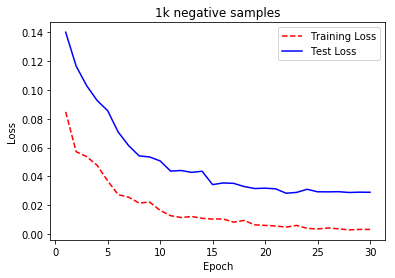

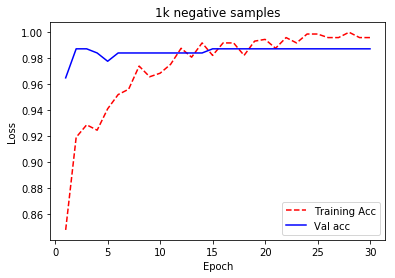

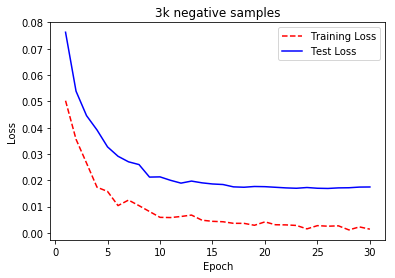

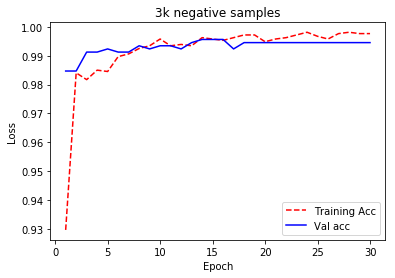

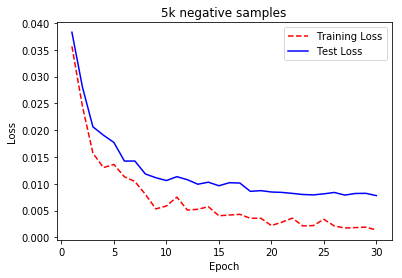

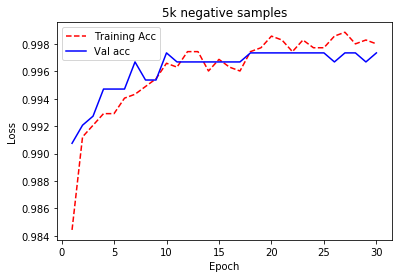

In [82]:
plot_history(history_1000,title="1k negative samples")
plot_history(history_3000,title="3k negative samples")
plot_history(history_5000,title="5k negative samples")

we see all three models behave in a similar fashion: 
- Learn to predict negative samples almost perfectly ( easiest).
- Make some errors predicting positive samples. 

We picked the model trained with 3000 negative samples as it renders the best f1_score. 

In [117]:
model_3000.save('resnet+dense_3000.hdf5')